# May 27th, 2022 (plot degree dist; adj on ctx)

**Motivation**: + brief look at Wasserstein distance between degree distributions <br>

In [1]:
# HIDE CODE


import os
import sys
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from numpy.ma import masked_where as mwh
from IPython.display import display, IFrame, HTML

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
_fig_dir = pjoin(git_dir, 'jb-Ca-fMRI/figs')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
lfr_dir = 'Documents/workspaces/lfr/binary_overlapping'
lfr_dir = pjoin(os.environ['HOME'], lfr_dir)

# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.fourier import *
from analysis.bootstrap import *
from analysis.svinet import *
from analysis.group import *
from analysis.lfr import *
from utils.render import *
from utils.plotting import *
from model.mouse import Mice
from model.configuration import Config

# RABIES
sys.path.insert(0, pjoin(git_dir, 'RABIES'))
from rabies.confound_correction_pkg.utils import butterworth as rb_butter

# set style & no interpolalation
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')
%matplotlib inline

# warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
def show_spectogram(spect_dict, xlim=None, figsize=None, title=None, show: bool = True):
    figsize = figsize if figsize else (10, 3 * len(spect_dict))
    fig, axes = create_figure(len(spect_dict), 2, figsize, 'col', 'row', width_ratios=[1, 0.4])
    kws = {
        'vmin': min(v[-1].mean(0).min() for v in spect_dict.values()),
        'vmax': max(v[-1].mean(0).max() for v in spect_dict.values()),
        'cmap': 'Spectral_r',
        'shading': 'gouraud',
        'norm': matplotlib.colors.LogNorm()
    }
    for i, (lbl, (_f, _t, _sxx)) in enumerate(spect_dict.items()):
        _sxx = _sxx.mean(0)
        im = axes[i, 0].pcolormesh(_t, _f, _sxx, **kws)
        plt.colorbar(im, ax=axes[i, 0])

        axes[i, 1].plot(_sxx.mean(1), _f, label=lbl)
        axes[i, 1].tick_params(
            axis='y',
            which='both',
            left=True,
            right=True,
            labelleft=False,
            labelright=True,
        )
        if i == 2:
            axes[i, 0].set_xlabel('Time [s]')
            axes[i, 1].set_xlabel('Power')
        axes[i, 0].set_ylabel('Frequency [Hz]')
        axes[i, 1].set_ylabel('Frequency [Hz]', rotation=-90, labelpad=20)
        axes[i, 1].yaxis.set_label_position('right')
        axes[i, 1].legend(loc='upper right')
        axes[i, 1].set_xscale('log')
        axes[i, 1].grid()
    if xlim is not None:
        axes[-1, -1].set_xlim(*xlim)
    sup = fig.suptitle(title if title else key, fontsize=17, y=1.01)
    if show:
        plt.show()
    else:
        plt.close()
    return fig, sup

## 128 * 3 (KABA)

In [3]:
mice = Mice(128)

mako = sns.color_palette('mako', as_cmap=True)
rocket = sns.color_palette('rocket', as_cmap=True)
pal = {'ca2': mako(0.6), 'bold-lite': rocket(0.6)}

In [4]:
%%time

rho = [0.05] + list(np.round(np.linspace(0.1, 0.2, 11), 2)) + [0.25]
bands = {
    'bold-lite': [0.01],
    'ca2': [0.01, 0.5, (0.01, 0.50)],
}
results = {}
for task in ['rest', 'led']:
    for mode, blist in bands.items():
        for b in blist:
            kws = {
                'band_ca' if
                mode == 'ca2'
                else 'band_bo': b,
                'task': task,
            }
            key = (task, mode, b)
            results[key] = collect_degrees(mice, mode, rho, **kws)

CPU times: user 10.9 s, sys: 1min 45s, total: 1min 55s
Wall time: 1min 58s


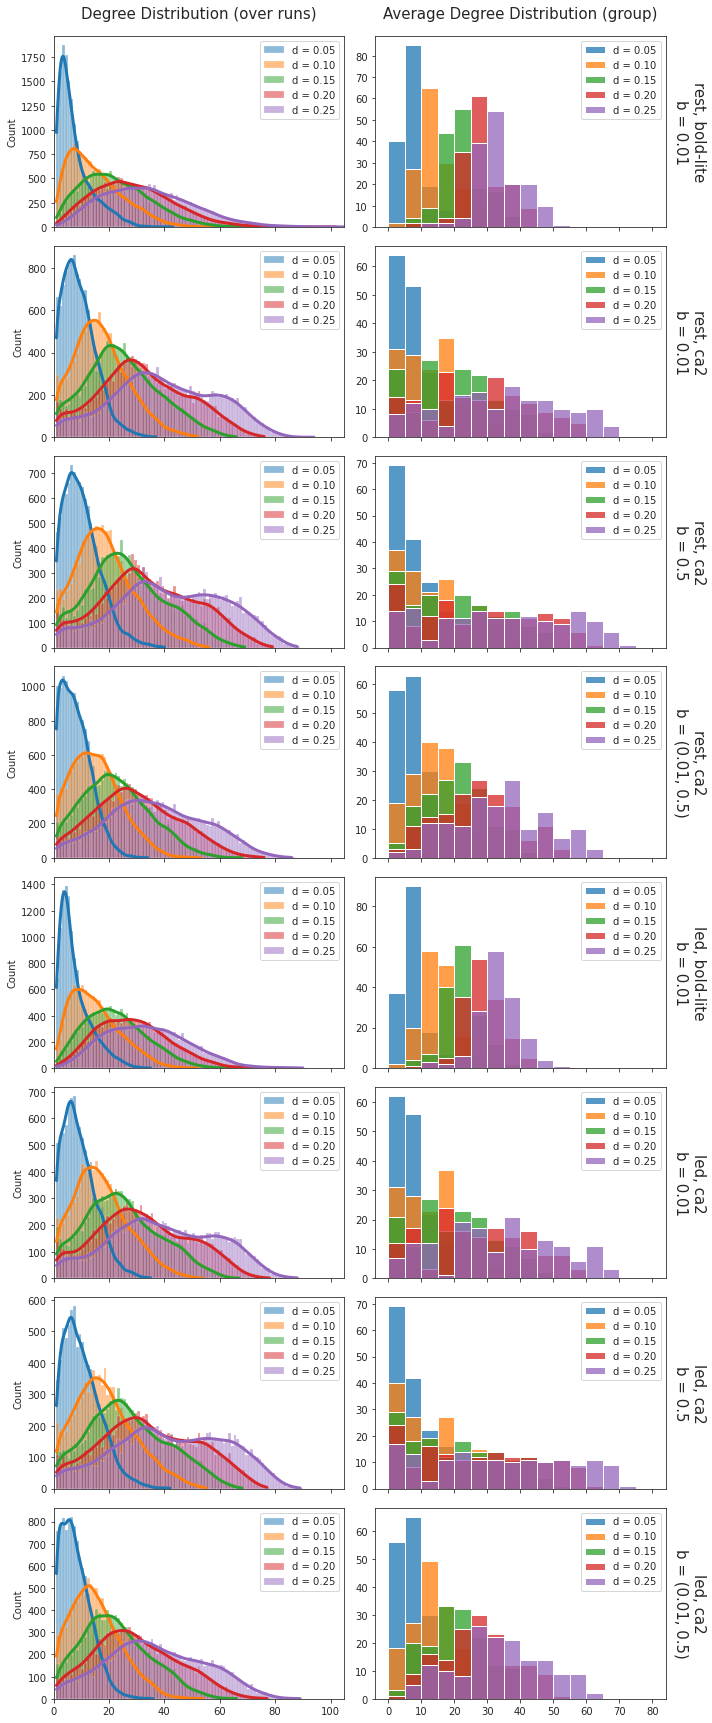

In [5]:
fig, axes = create_figure(len(results), 2, (10, 3.0 * len(results)), 'col')
for i, (key, res_dict) in enumerate(results.items()):
    task, mode, b = key
    for j, d in enumerate([0.05, 0.10, 0.15, 0.20, 0.25]):
        x = res_dict['deg'][d]
        sns.histplot(
            x[x.nonzero()],
            kde=True,
            line_kws={'lw': 3},
            bins=np.linspace(0, 100, 101),
            color=f'C{j}',
            label=f"d = {d:0.2f}",
            ax=axes[i, 0],
        )
        sns.histplot(
            res_dict['deg_avg'][d],
            bins=np.linspace(0, 80, 17),
            color=f'C{j}',
            label=f"d = {d:0.2f}",
            ax=axes[i, 1],
        )
        # axes[i, 1].set_ylabel('')
        axes[i, 1].set_ylabel(f"{task}, {mode}\nb = {b}", fontsize=15, labelpad=40, rotation=-90)
        axes[i, 1].yaxis.set_label_position("right")

axes[0, 0].set_title('Degree Distribution (over runs)', fontsize=15, y=1.06)
axes[0, 1].set_title('Average Degree Distribution (group)', fontsize=15, y=1.06)
axes[-1, 0].set_xlim(0, 105)
for ax in axes.flat:
    ax.legend()
plt.show()

In [6]:
r1 = results[('rest', 'ca2', (0.01, 0.5))]
r2 = results[('rest', 'bold-lite', 0.01)]

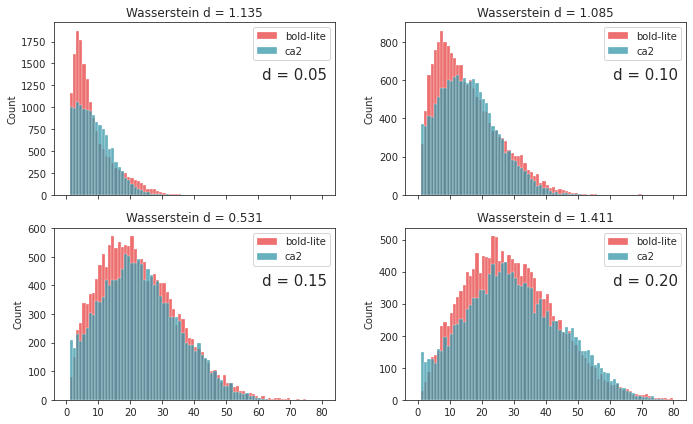

In [7]:
fig, axes = create_figure(2, 2, (10, 6), 'all')

for ax, d in zip(axes.flat, np.round(np.linspace(0.05, 0.20, 4), 2)):
    x1 = r1['deg'][d] 
    x2 = r2['deg'][d]
    
    sns.histplot(
        x2[x2.nonzero()],
        color=pal['bold-lite'],
        bins=np.linspace(0, 80, 81),
        label='bold-lite',
        ax=ax,
    )
    sns.histplot(
        x1[x1.nonzero()],
        color=pal['ca2'],
        bins=np.linspace(0, 80, 81),
        label='ca2',
        ax=ax,
    )
    ax.annotate(
        text=f"d = {d:0.2f}",
        xy=(208, 115),
        xycoords='axes pixels',
        fontsize=15,
    )
    wasser = sp_stats.wasserstein_distance(x1[x1.nonzero()], x2[x2.nonzero()])
    ax.set_title(f"Wasserstein d = {wasser:0.3f}")
    ax.legend()
plt.show()

In [8]:
dlist = []
r1 = results[('rest', 'bold-lite', 0.01)]
for d, x1 in r1['deg'].items():
    for b in [0.01, 0.5, (0.01, 0.5)]:
        r2 = results[('rest', 'ca2', b)]
        x2 = r2['deg'][d]
        wasser = sp_stats.wasserstein_distance(
            x1[x1.nonzero()], x2[x2.nonzero()])
        dlist.append({
            'density': [d],
            'band': [b],
            'distance': [wasser],
        })
df = pd.DataFrame(merge_dicts(dlist))

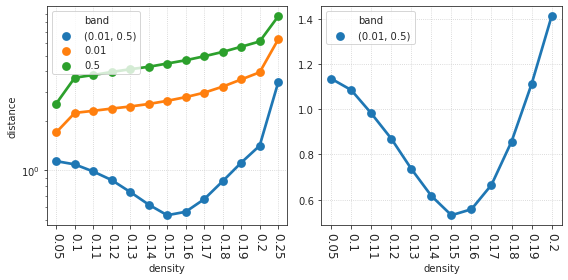

In [9]:
fig, axes = create_figure(1, 2, (8, 4))
sns.pointplot(
    data=df,
    x='density',
    y='distance',
    hue='band',
    hue_order=[(0.01, 0.5), 0.01, 0.5],
    ax=axes[0],
)
axes[0].set_yscale('log')

_df = df.loc[
    (df['density'] < 0.25) &
    (df['band'] == (0.01, 0.5))
]
sns.pointplot(data=_df, x='density', y='distance', hue='band', ax=axes[1])
for ax in axes.flat:
    ax.tick_params(axis='x', rotation=-90, labelsize=12)
    ax.grid()
axes[1].set_ylabel('')
plt.show()

In [10]:
dlist = []
r1 = results[('rest', 'bold-lite', 0.01)]
densities = list(r1['deg'])
for d1, d2 in itertools.product(densities, densities):
    for b in [0.01, 0.5, (0.01, 0.5)]:
        r2 = results[('rest', 'ca2', b)]
        
        x1 = r1['deg'][d1]
        x2 = r2['deg'][d2]
        wasser = sp_stats.wasserstein_distance(
            x1[x1.nonzero()], x2[x2.nonzero()])
        dlist.append({
            'b': [b],
            'd1': [d1],
            'd2': [d2],
            'distance': [wasser],
        })
df = pd.DataFrame(merge_dicts(dlist))

In [11]:
_df = df.loc[
    (df['b'] == (0.01, 0.5)) &
    (df['d1'] > 0.05) &
    (df['d1'] < 0.25) &
    (df['d2'] > 0.05) &
    (df['d2'] < 0.25)
]
_df = _df.pivot_table(values='distance', index='d1', columns='d2')

<AxesSubplot:xlabel='d2', ylabel='d1'>

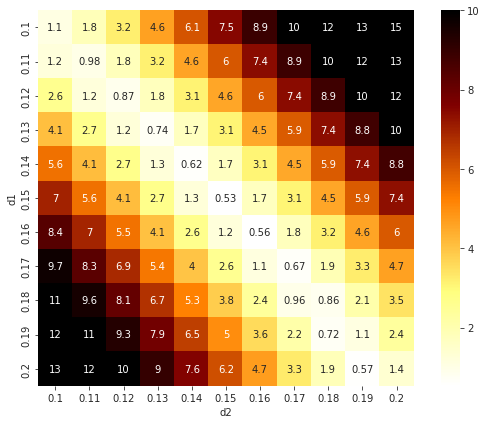

In [12]:
fig, ax = create_figure(1, 1, (8, 6))
sns.heatmap(_df, cmap='afmhot_r', vmax=10, square=True, annot=True, ax=ax)

In [13]:
dlist = []
r1 = results[('led', 'bold-lite', 0.01)]
densities = list(r1['deg'])
for d1, d2 in itertools.product(densities, densities):
    for b in [0.01, 0.5, (0.01, 0.5)]:
        r2 = results[('led', 'ca2', b)]
        
        x1 = r1['deg'][d1]
        x2 = r2['deg'][d2]
        wasser = sp_stats.wasserstein_distance(
            x1[x1.nonzero()], x2[x2.nonzero()])
        dlist.append({
            'b': [b],
            'd1': [d1],
            'd2': [d2],
            'distance': [wasser],
        })
df = pd.DataFrame(merge_dicts(dlist))

In [14]:
_df = df.loc[
    (df['b'] == (0.01, 0.5)) &
    (df['d1'] > 0.05) &
    (df['d1'] < 0.25) &
    (df['d2'] > 0.05) &
    (df['d2'] < 0.25)
]
_df = _df.pivot_table(values='distance', index='d1', columns='d2')

<AxesSubplot:xlabel='d2', ylabel='d1'>

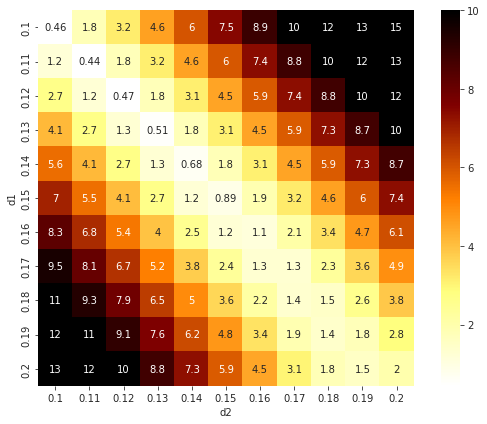

In [15]:
fig, ax = create_figure(1, 1, (8, 6))
sns.heatmap(_df, cmap='afmhot_r', vmax=10, square=True, annot=True, ax=ax)

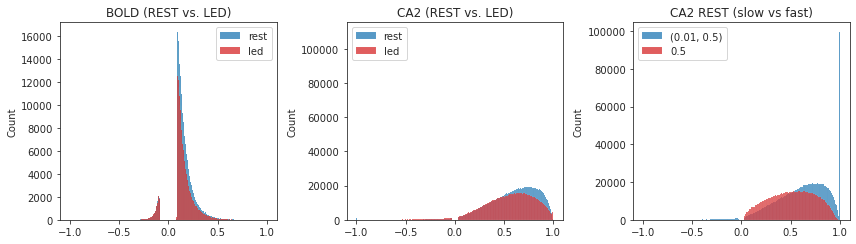

In [16]:
fig, axes = create_figure(1, 3, (12, 3.5), 'all')

r1 = results[('rest', 'bold-lite', 0.01)]
r2 = results[('led', 'bold-lite', 0.01)]
sns.histplot(r1['adj'][r1['adj'].nonzero()], label='rest', color='C0', ax=axes[0])
sns.histplot(r2['adj'][r2['adj'].nonzero()], label='led', color='C3', ax=axes[0])
axes[0].set_title('BOLD (REST vs. LED)')
axes[0].legend()

r1 = results[('rest', 'ca2', (0.01, 0.5))]
r2 = results[('led', 'ca2', (0.01, 0.5))]
sns.histplot(r1['adj'][r1['adj'].nonzero()], label='rest', color='C0', ax=axes[1])
sns.histplot(r2['adj'][r2['adj'].nonzero()], label='led', color='C3', ax=axes[1])
axes[1].set_title('CA2 (REST vs. LED)')
axes[1].legend()

r1 = results[('rest', 'ca2', (0.01, 0.5))]
r2 = results[('led', 'ca2', 0.5)]
sns.histplot(r1['adj'][r1['adj'].nonzero()], label='(0.01, 0.5)', color='C0', ax=axes[2])
sns.histplot(r2['adj'][r2['adj'].nonzero()], label='0.5', color='C3', ax=axes[2])
axes[2].set_title('CA2 REST (slow vs fast)')
axes[2].legend()

plt.show()

In [17]:
gr = Group(mice=mice, mode='ca2')

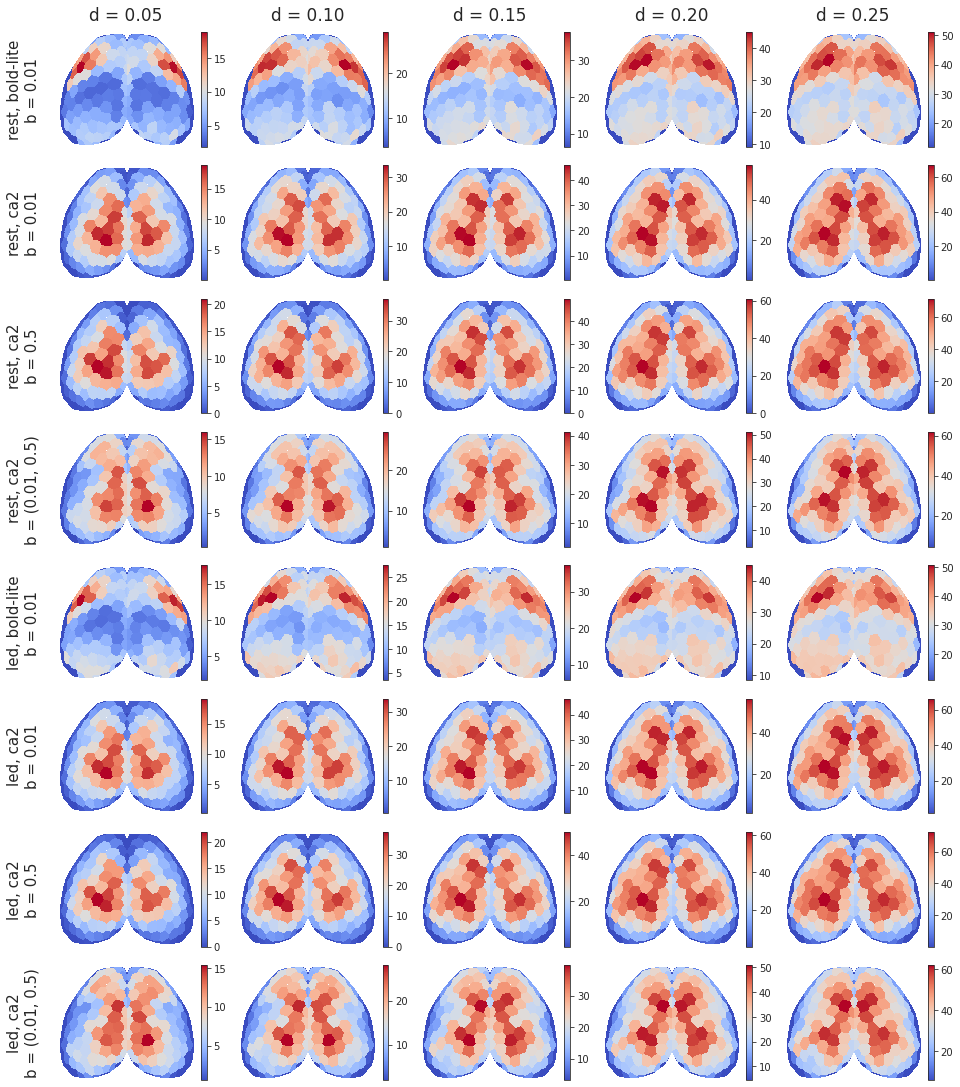

In [18]:
densities = np.round(np.linspace(0.05, 0.25, 5), 2)
fig, axes = create_figure(len(results), len(densities), (13.5, 1.9 * len(results)))

for i, (key, res_dict) in enumerate(results.items()):
    task, mode, b = key
    for j, d in enumerate(densities):
        tr = gr.project_vec(
            vec=res_dict['deg_avg'][d],
            add_disjoint=False,
        )
        tr = gr.trim2d(tr)
        ax = axes[i, j]
        ax.imshow(mwh(tr['top'] == 0, tr['top']), cmap='Greys_r')
        im = ax.imshow(
            mwh(tr['top'] == 0, tr['proj-top'][0]),
            vmin=np.min(res_dict['deg_avg'][d]),
            vmax=np.max(res_dict['deg_avg'][d]),
            cmap='coolwarm',
        )
        plt.colorbar(im, ax=ax)
        if i == 0:
            ax.set_title(f"d = {d:0.2f}", fontsize=17, y=1.07)
        if j == 0:
            ax.set_ylabel(f"{task}, {mode}\nb = {b}", fontsize=15, labelpad=20)
remove_ticks(axes)
plt.show()

## 512 * 3 (GABAN)

In [6]:
mice = Mice(512)

mako = sns.color_palette('mako', as_cmap=True)
rocket = sns.color_palette('rocket', as_cmap=True)
pal = {'ca2': mako(0.6), 'bold-lite': rocket(0.6)}

In [7]:
%%time

rho = [0.05] + list(np.round(np.linspace(0.1, 0.2, 11), 2)) + [0.25]
bands = {
    'bold-lite': [0.01],
    'ca2': [0.01, 0.5, (0.01, 0.50)],
}
results = {}
for task in ['rest', 'led']:
    for mode, blist in bands.items():
        for b in blist:
            kws = {
                'band_ca' if
                mode == 'ca2'
                else 'band_bo': b,
                'task': task,
            }
            key = (task, mode, b)
            results[key] = collect_degrees(mice, mode, rho, **kws)

CPU times: user 51.7 s, sys: 6min 56s, total: 7min 48s
Wall time: 8min 7s


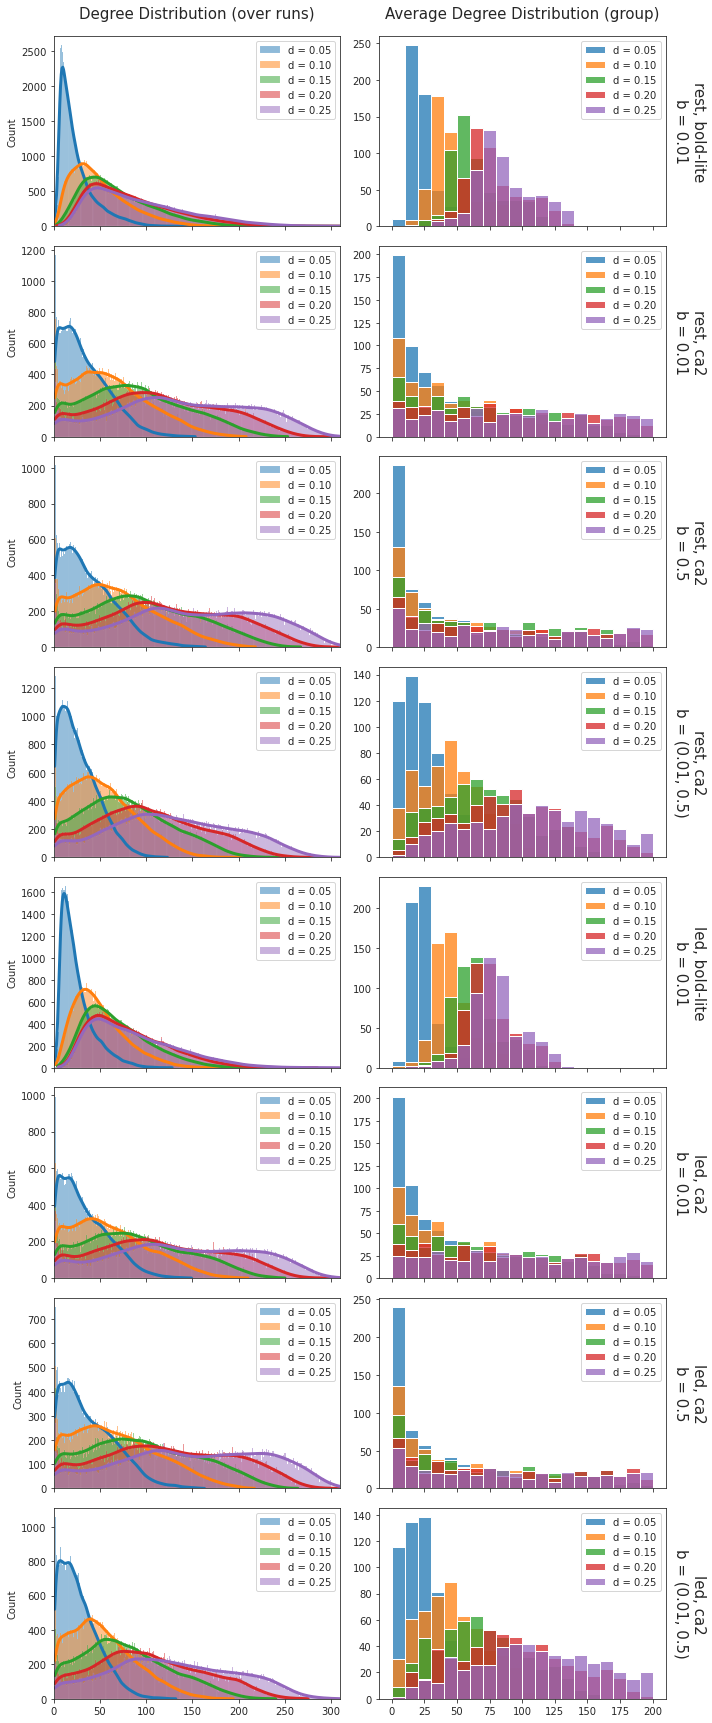

In [25]:
fig, axes = create_figure(len(results), 2, (10, 3.0 * len(results)), 'col')
for i, (key, res_dict) in enumerate(results.items()):
    task, mode, b = key
    for j, d in enumerate([0.05, 0.10, 0.15, 0.20, 0.25]):
        x = res_dict['deg'][d]
        sns.histplot(
            x[x.nonzero()],
            kde=True,
            line_kws={'lw': 3},
            bins=np.linspace(0, 300, 301),
            color=f'C{j}',
            label=f"d = {d:0.2f}",
            ax=axes[i, 0],
        )
        sns.histplot(
            res_dict['deg_avg'][d],
            bins=np.linspace(0, 200, 21),
            color=f'C{j}',
            label=f"d = {d:0.2f}",
            ax=axes[i, 1],
        )
        # axes[i, 1].set_ylabel('')
        axes[i, 1].set_ylabel(f"{task}, {mode}\nb = {b}", fontsize=15, labelpad=40, rotation=-90)
        axes[i, 1].yaxis.set_label_position("right")

axes[0, 0].set_title('Degree Distribution (over runs)', fontsize=15, y=1.06)
axes[0, 1].set_title('Average Degree Distribution (group)', fontsize=15, y=1.06)
axes[-1, 0].set_xlim(0, 310)
for ax in axes.flat:
    ax.legend()
plt.show()

In [26]:
r1 = results[('rest', 'ca2', (0.01, 0.5))]
r2 = results[('rest', 'bold-lite', 0.01)]

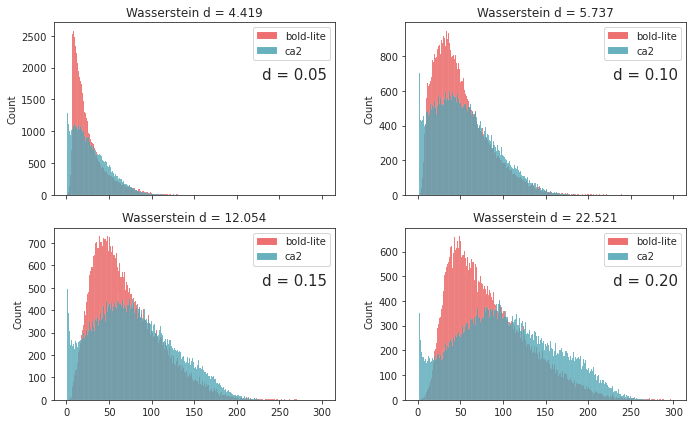

In [27]:
fig, axes = create_figure(2, 2, (10, 6), 'all')

for ax, d in zip(axes.flat, np.round(np.linspace(0.05, 0.20, 4), 2)):
    x1 = r1['deg'][d] 
    x2 = r2['deg'][d]
    
    sns.histplot(
        x2[x2.nonzero()],
        color=pal['bold-lite'],
        bins=np.linspace(0, 300, 301),
        label='bold-lite',
        ax=ax,
    )
    sns.histplot(
        x1[x1.nonzero()],
        color=pal['ca2'],
        bins=np.linspace(0, 300, 301),
        label='ca2',
        ax=ax,
    )
    ax.annotate(
        text=f"d = {d:0.2f}",
        xy=(208, 115),
        xycoords='axes pixels',
        fontsize=15,
    )
    wasser = sp_stats.wasserstein_distance(x1[x1.nonzero()], x2[x2.nonzero()])
    ax.set_title(f"Wasserstein d = {wasser:0.3f}")
    ax.legend()
plt.show()

In [11]:
dlist = []
r1 = results[('rest', 'bold-lite', 0.01)]
for d, x1 in r1['deg'].items():
    for b in [0.01, 0.5, (0.01, 0.5)]:
        r2 = results[('rest', 'ca2', b)]
        x2 = r2['deg'][d]
        wasser = sp_stats.wasserstein_distance(
            x1[x1.nonzero()], x2[x2.nonzero()])
        dlist.append({
            'density': [d],
            'band': [b],
            'distance': [wasser],
        })
df = pd.DataFrame(merge_dicts(dlist))

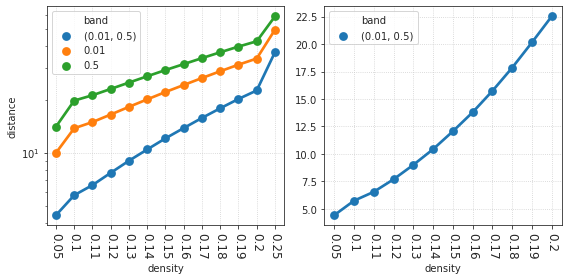

In [12]:
fig, axes = create_figure(1, 2, (8, 4))
sns.pointplot(
    data=df,
    x='density',
    y='distance',
    hue='band',
    hue_order=[(0.01, 0.5), 0.01, 0.5],
    ax=axes[0],
)
axes[0].set_yscale('log')

_df = df.loc[
    (df['density'] < 0.25) &
    (df['band'] == (0.01, 0.5))
]
sns.pointplot(data=_df, x='density', y='distance', hue='band', ax=axes[1])
for ax in axes.flat:
    ax.tick_params(axis='x', rotation=-90, labelsize=12)
    ax.grid()
axes[1].set_ylabel('')
plt.show()

In [28]:
dlist = []
r1 = results[('rest', 'bold-lite', 0.01)]
densities = list(r1['deg'])
for d1, d2 in itertools.product(densities, densities):
    for b in [0.01, 0.5, (0.01, 0.5)]:
        r2 = results[('rest', 'ca2', b)]
        
        x1 = r1['deg'][d1]
        x2 = r2['deg'][d2]
        wasser = sp_stats.wasserstein_distance(
            x1[x1.nonzero()], x2[x2.nonzero()])
        dlist.append({
            'b': [b],
            'd1': [d1],
            'd2': [d2],
            'distance': [wasser],
        })
df = pd.DataFrame(merge_dicts(dlist))

In [29]:
_df = df.loc[
    (df['b'] == (0.01, 0.5)) &
    (df['d1'] > 0.05) &
    (df['d1'] < 0.25) &
    (df['d2'] > 0.05) &
    (df['d2'] < 0.25)
]
_df = _df.pivot_table(values='distance', index='d1', columns='d2')

<AxesSubplot:xlabel='d2', ylabel='d1'>

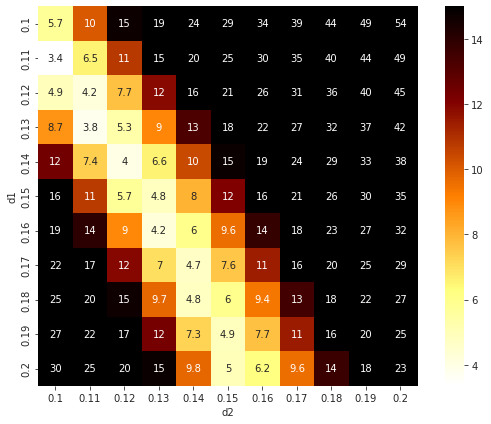

In [31]:
fig, ax = create_figure(1, 1, (8, 6))
sns.heatmap(_df, cmap='afmhot_r', vmax=15, square=True, annot=True, ax=ax)

In [32]:
dlist = []
r1 = results[('led', 'bold-lite', 0.01)]
densities = list(r1['deg'])
for d1, d2 in itertools.product(densities, densities):
    for b in [0.01, 0.5, (0.01, 0.5)]:
        r2 = results[('led', 'ca2', b)]
        
        x1 = r1['deg'][d1]
        x2 = r2['deg'][d2]
        wasser = sp_stats.wasserstein_distance(
            x1[x1.nonzero()], x2[x2.nonzero()])
        dlist.append({
            'b': [b],
            'd1': [d1],
            'd2': [d2],
            'distance': [wasser],
        })
df = pd.DataFrame(merge_dicts(dlist))

In [33]:
_df = df.loc[
    (df['b'] == (0.01, 0.5)) &
    (df['d1'] > 0.05) &
    (df['d1'] < 0.25) &
    (df['d2'] > 0.05) &
    (df['d2'] < 0.25)
]
_df = _df.pivot_table(values='distance', index='d1', columns='d2')

<AxesSubplot:xlabel='d2', ylabel='d1'>

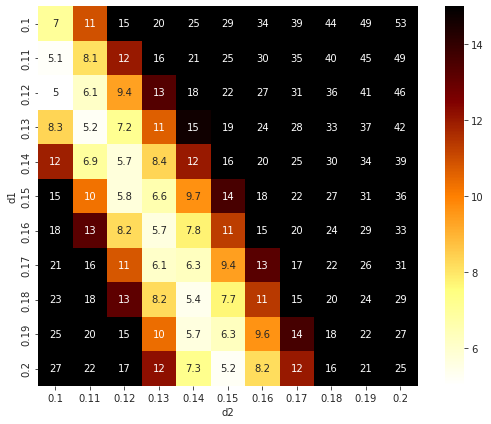

In [34]:
fig, ax = create_figure(1, 1, (8, 6))
sns.heatmap(_df, cmap='afmhot_r', vmax=15, square=True, annot=True, ax=ax)

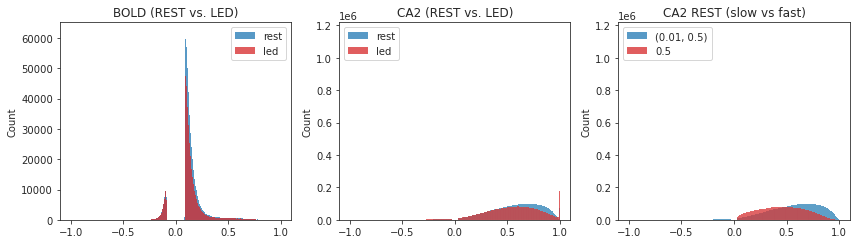

In [19]:
fig, axes = create_figure(1, 3, (12, 3.5), 'all')

r1 = results[('rest', 'bold-lite', 0.01)]
r2 = results[('led', 'bold-lite', 0.01)]
sns.histplot(r1['adj'][r1['adj'].nonzero()], label='rest', color='C0', ax=axes[0])
sns.histplot(r2['adj'][r2['adj'].nonzero()], label='led', color='C3', ax=axes[0])
axes[0].set_title('BOLD (REST vs. LED)')
axes[0].legend()

r1 = results[('rest', 'ca2', (0.01, 0.5))]
r2 = results[('led', 'ca2', (0.01, 0.5))]
sns.histplot(r1['adj'][r1['adj'].nonzero()], label='rest', color='C0', ax=axes[1])
sns.histplot(r2['adj'][r2['adj'].nonzero()], label='led', color='C3', ax=axes[1])
axes[1].set_title('CA2 (REST vs. LED)')
axes[1].legend()

r1 = results[('rest', 'ca2', (0.01, 0.5))]
r2 = results[('led', 'ca2', 0.5)]
sns.histplot(r1['adj'][r1['adj'].nonzero()], label='(0.01, 0.5)', color='C0', ax=axes[2])
sns.histplot(r2['adj'][r2['adj'].nonzero()], label='0.5', color='C3', ax=axes[2])
axes[2].set_title('CA2 REST (slow vs fast)')
axes[2].legend()

plt.show()

In [20]:
gr = Group(mice=mice, mode='ca2')

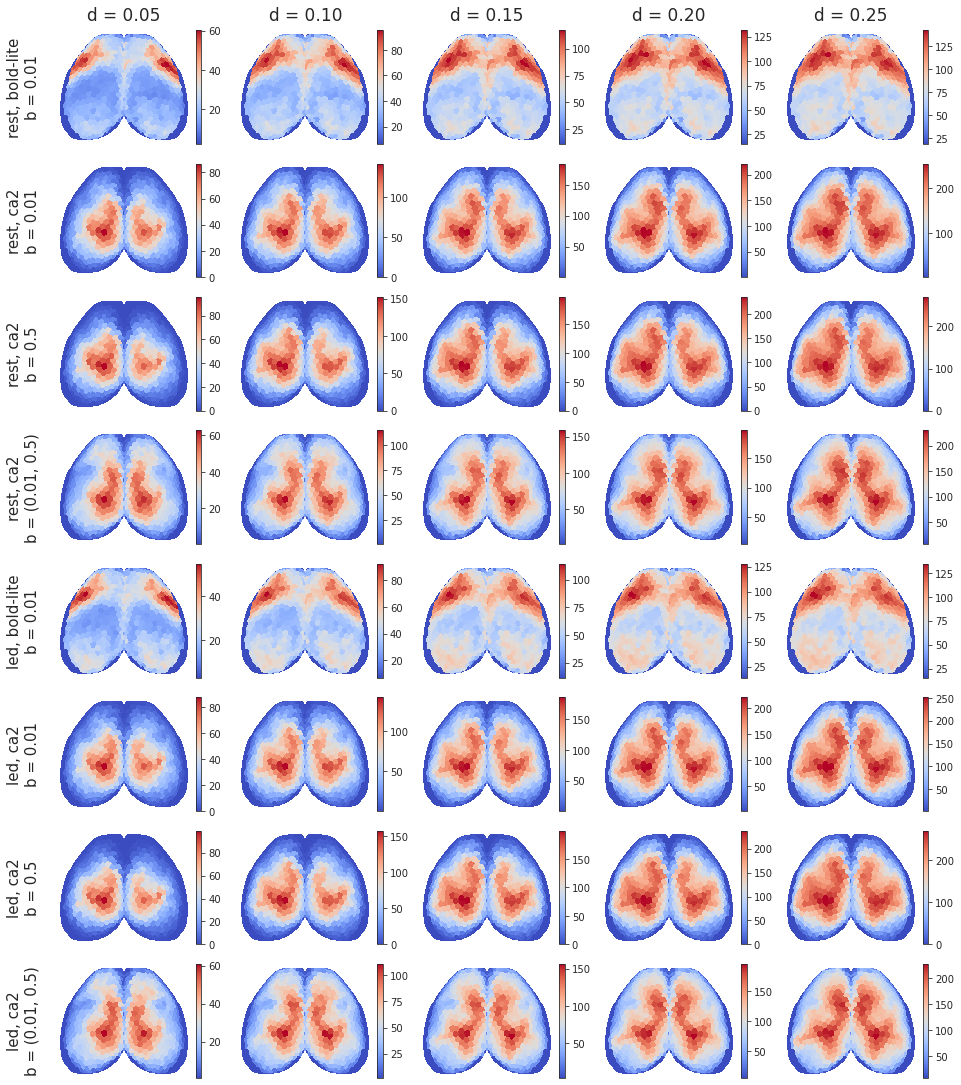

In [21]:
densities = np.round(np.linspace(0.05, 0.25, 5), 2)
fig, axes = create_figure(len(results), len(densities), (13.5, 1.9 * len(results)))

for i, (key, res_dict) in enumerate(results.items()):
    task, mode, b = key
    for j, d in enumerate(densities):
        tr = gr.project_vec(
            vec=res_dict['deg_avg'][d],
            add_disjoint=False,
        )
        tr = gr.trim2d(tr)
        ax = axes[i, j]
        ax.imshow(mwh(tr['top'] == 0, tr['top']), cmap='Greys_r')
        im = ax.imshow(
            mwh(tr['top'] == 0, tr['proj-top'][0]),
            vmin=np.min(res_dict['deg_avg'][d]),
            vmax=np.max(res_dict['deg_avg'][d]),
            cmap='coolwarm',
        )
        plt.colorbar(im, ax=ax)
        if i == 0:
            ax.set_title(f"d = {d:0.2f}", fontsize=17, y=1.07)
        if j == 0:
            ax.set_ylabel(f"{task}, {mode}\nb = {b}", fontsize=15, labelpad=20)
remove_ticks(axes)
plt.show()